# Import Required Libraries
Import all necessary libraries including numpy, pandas, gurobipy, matplotlib, and seaborn.

In [53]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist
from typing import List, Dict, Tuple

# Data Generation
Generate synthetic data for persons and hospitals using the DataGenerator class.

In [75]:
class DataGenerator:
    def __init__(self, n_persons: int, n_hospitals: int, n_vaccines: int, seed: int = 42):
        self.n_persons = n_persons
        self.n_hospitals = n_hospitals
        self.n_vaccines = n_vaccines
        np.random.seed(seed)
        
    def generate(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        # Generate person data
        persons = pd.DataFrame({
            'id': range(self.n_persons),
            'x': np.random.uniform(0, 100, self.n_persons),
            'y': np.random.uniform(0, 100, self.n_persons),
            'priority': np.random.randint(1, 6, self.n_persons)  # Priority 1-5
        })
        
        # Generate hospital data
        hospitals = pd.DataFrame({
            'id': range(self.n_hospitals),
            'x': np.random.uniform(0, 100, self.n_hospitals),
            'y': np.random.uniform(0, 100, self.n_hospitals),
            'staff': np.random.randint(8, 10, self.n_hospitals)  # 3-7 staff per hospital
        })
        
        return persons, hospitals

# Example usage
data_gen = DataGenerator(n_persons=1000, n_hospitals=5, n_vaccines=450)
persons, hospitals = data_gen.generate()

# Display the generated data
persons.head(), hospitals.head()

(   id          x          y  priority
 0   0  37.454012  18.513293         4
 1   1  95.071431  54.190095         3
 2   2  73.199394  87.294584         4
 3   3  59.865848  73.222489         2
 4   4  15.601864  80.656115         2,
    id          x          y  staff
 0   0  65.911376  95.302002      8
 1   1  10.889331  52.253972      8
 2   2  63.653865  21.911748      9
 3   3  49.823600  45.896348      9
 4   4  40.667407  91.938740      9)

# Clustering and Distance Calculation
Perform clustering to select distribution centers and calculate the distance matrix.

In [76]:
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np

class ClusteringService:
    def __init__(self, n_clusters: int, random_state: int = 42):
        self.n_clusters = n_clusters
        self.random_state = random_state
    
    def calculate_distances(self, point1: np.ndarray, point2: np.ndarray) -> float:
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def get_distance_matrix(self, persons: pd.DataFrame, hospitals: pd.DataFrame) -> np.ndarray:
        """Create distance matrix between persons and hospitals"""
        n_persons = len(persons)
        n_hospitals = len(hospitals)
        distances = np.zeros((n_persons, n_hospitals))
        
        for i in range(n_persons):
            person_loc = persons[['x', 'y']].iloc[i].values
            for j in range(n_hospitals):
                hospital_loc = hospitals[['x', 'y']].iloc[j].values
                distances[i,j] = self.calculate_distances(person_loc, hospital_loc)
                
        return distances
    
    def select_distribution_centers(self, hospitals: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray]:
        """Select distribution centers using K-medoids clustering"""
        locations = hospitals[['x', 'y']].values
        kmedoids = KMedoids(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            method='pam'

        )
        clusters = kmedoids.fit(locations)
        selected_centers = hospitals.iloc[kmedoids.medoid_indices_].copy()
        
        return selected_centers, clusters.labels_

# Example usage
clustering = ClusteringService(n_clusters=4)
centers, labels = clustering.select_distribution_centers(hospitals)
distances = clustering.get_distance_matrix(persons, centers)

# Display the clustering results and distance matrix
centers.head(), labels[:10], distances[:5, :5]

(   id          x          y  staff
 3   3  49.823600  45.896348      9
 2   2  63.653865  21.911748      9
 1   1  10.889331  52.253972      8
 0   0  65.911376  95.302002      8,
 array([3, 2, 1, 0, 3]),
 array([[30.04726968, 26.41934486, 42.94316773, 81.89216973],
        [46.00165659, 45.04392437, 84.20436096, 50.40334998],
        [47.54199897, 66.07595879, 71.48698068, 10.82746295],
        [29.11296478, 51.45037588, 53.27642934, 22.892211  ],
        [48.77877209, 75.89397473, 28.79044455, 52.39798712]]))

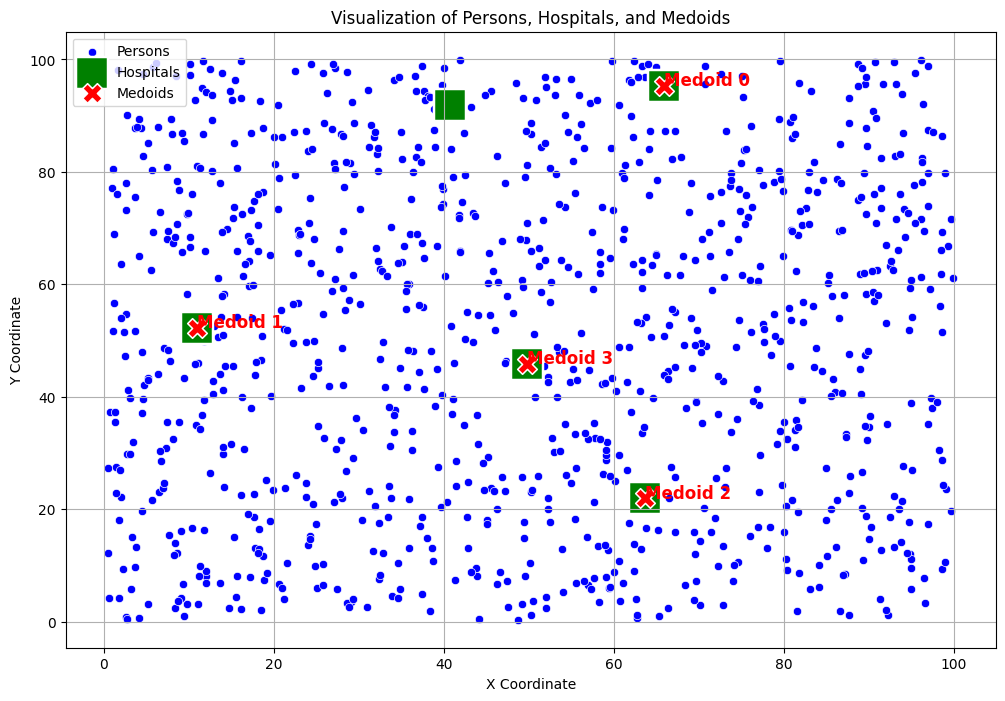

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data
def plot_medoids(persons: pd.DataFrame, hospitals: pd.DataFrame, centers: pd.DataFrame, labels: np.ndarray):
    plt.figure(figsize=(12, 8))
    
    # Plot persons
    sns.scatterplot(x='x', y='y', data=persons, label='Persons', marker='o', color='blue')
    
    # Plot hospitals
    sns.scatterplot(x='x', y='y', data=hospitals, label='Hospitals', marker='s', color='green', s=500)
    
    # Plot medoids (distribution centers)
    sns.scatterplot(x='x', y='y', data=centers, label='Medoids', marker='X', color='red', s=200)
    
    # Annotate medoids
    for i, center in centers.iterrows():
        plt.text(center['x'], center['y'], f'Medoid {i}', fontsize=12, weight='bold', color='red')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of Persons, Hospitals, and Medoids')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_medoids(persons, hospitals, centers, labels)

# Optimization Parameters Setup
Set up the optimization parameters including alpha, beta, and gamma.

In [78]:
# Optimization Parameters Setup

from dataclasses import dataclass

@dataclass
class OptimizationParameters:
    alpha: float  # Base reward for vaccination
    beta: float   # Priority weight
    gamma: float  # Distance penalty

# Set optimization parameters
params = OptimizationParameters(
    alpha=0.25 * len(persons),
    beta=0.25 * len(persons),
    gamma=1.0
)

# Display the optimization parameters
params

OptimizationParameters(alpha=250.0, beta=250.0, gamma=1.0)

# Vaccine Distribution Models
Implement and solve various vaccine distribution models.

In [ ]:
class VaccineOptimizer:
    def __init__(self, persons: pd.DataFrame, centers: pd.DataFrame, distances: np.ndarray, n_vaccines: int, params: OptimizationParameters):
        self.persons = persons
        self.centers = centers
        self.distances = distances
        self.n_vaccines = n_vaccines
        self.params = params

    def create_base_model(self) -> gp.Model:
        """Creates base model with common constraints"""
        model = gp.Model("Vaccine_Distribution")
        
        # Sets
        I = range(len(self.centers))    # Distribution centers
        J = range(sum(self.centers['staff'])) # Healthcare workers
        K = range(len(self.persons))    # Persons
        
        # Decision Variables
        x = model.addVars(I, J, K, vtype=GRB.BINARY, name="x")
        
        # Constraints
        # Each worker can vaccinate at most one person
        for i in I:
            for j in J:
                model.addConstr(gp.quicksum(x[i,j,k] for k in K) <= 1)
                
        # Each person gets at most one vaccine
        for k in K:
            model.addConstr(gp.quicksum(x[i,j,k] for i in I for j in J) <= 1)
            
        # Cannot exceed vaccine supply
        model.addConstr(gp.quicksum(x[i,j,k] for i in I for j in J for k in K) <= self.n_vaccines)
        
        return model, x

    def solve_bvdm(self) -> Dict:
        """Basic Vaccine Distribution Model"""
        model, x = self.create_base_model()
        
        # Objective: Maximize number of vaccinations
        obj = gp.quicksum(self.params.alpha * x[i,j,k] 
                         for i in range(len(self.centers))
                         for j in range(sum(self.centers['staff']))
                         for k in range(len(self.persons)))
        model.setObjective(obj, GRB.MAXIMIZE)
        
        model.optimize()
        return self._get_solution(model, x)

    def solve_pvdm(self) -> Dict:
        """Priority-based Vaccine Distribution Model"""
        model, x = self.create_base_model()
        
        # Objective: Maximize vaccinations considering priority
        obj = gp.quicksum((self.params.alpha + self.params.beta * self.persons.loc[k, 'priority']) * x[i,j,k]
                            for i in range(len(self.centers))
                            for j in range(sum(self.centers['staff']))
                            for k in range(len(self.persons)))
        model.setObjective(obj, GRB.MAXIMIZE)
        
        model.optimize()
        return self._get_solution(model, x)

    def solve_dvdm(self) -> Dict:
        """Distance-based Vaccine Distribution Model"""
        model, x = self.create_base_model()
        
        # Objective: Minimize travel distance
        obj = gp.quicksum((self.params.alpha - self.params.gamma * self.distances[k,i]) * x[i,j,k]
                            for i in range(len(self.centers))
                            for j in range(sum(self.centers['staff']))
                            for k in range(len(self.persons)))
        model.setObjective(obj, GRB.MAXIMIZE)
        
        model.optimize()
        return self._get_solution(model, x)

    def solve_pdvdm(self) -> Dict:
        """Priority and Distance-based Vaccine Distribution Model"""
        model, x = self.create_base_model()
        
        # Objective: Maximize vaccinations considering priority and minimize travel distance
        obj = gp.quicksum((self.params.alpha + self.params.beta * self.persons.loc[k, 'priority'] - self.params.gamma * self.distances[k,i]) * x[i,j,k]
                            for i in range(len(self.centers))
                            for j in range(sum(self.centers['staff']))
                            for k in range(len(self.persons)))
        model.setObjective(obj, GRB.MAXIMIZE)
        
        model.optimize()
        return self._get_solution(model, x)

    def _get_solution(self, model: gp.Model, x: gp.tupledict) -> Dict:
        """Extract solution details"""
        if model.Status == GRB.OPTIMAL:
            solution = {
                'objective_value': model.ObjVal,
                'assignments': [],
                'total_vaccinated': 0
            }
            
            for i in range(len(self.centers)):
                for j in range(sum(self.centers['staff'])):
                    for k in range(len(self.persons)):
                        if x[i,j,k].X > 0.5:  # Binary variable threshold
                            solution['assignments'].append({
                                'center': i,
                                'worker': j,
                                'person': k,
                                'priority': self.persons.loc[k, 'priority'],
                                'distance': self.distances[k,i]
                            })
                            solution['total_vaccinated'] += 1
                            
            return solution
        return {'error': 'No optimal solution found'}

# Example usage
optimizer = VaccineOptimizer(persons, centers, distances, n_vaccines= data_gen.n_vaccines, params=params)

# Solve all models
results = {
    'B-VDM': optimizer.solve_bvdm(),
    'P-VDM': optimizer.solve_pvdm(),
    'D-VDM': optimizer.solve_dvdm(),
    'PD-VDM': optimizer.solve_pdvdm()
}

# Display the results
results

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i9-14900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 1137 rows, 136000 columns and 408000 nonzeros
Model fingerprint: 0x78236dc4
Variable types: 0 continuous, 136000 integer (136000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 112500.00000
Presolve time: 0.17s
Presolved: 1137 rows, 136000 columns, 408000 nonzeros
Variable types: 0 continuous, 136000 integer (136000 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: cutoff, 2 iterations, 0.08 seconds (0.16 work units)

    Nodes    |    Current Node    |     Obj

{'B-VDM': {'objective_value': 112500.0,
  'assignments': [{'center': 0,
    'worker': 0,
    'person': 0,
    'priority': 4,
    'distance': 30.04726968394291},
   {'center': 0,
    'worker': 0,
    'person': 1,
    'priority': 3,
    'distance': 46.001656591713356},
   {'center': 0,
    'worker': 0,
    'person': 2,
    'priority': 4,
    'distance': 47.54199897133503},
   {'center': 0,
    'worker': 0,
    'person': 3,
    'priority': 2,
    'distance': 29.112964776071752},
   {'center': 0,
    'worker': 0,
    'person': 4,
    'priority': 2,
    'distance': 48.77877208990486},
   {'center': 0,
    'worker': 0,
    'person': 5,
    'priority': 1,
    'distance': 39.63044512974203},
   {'center': 0,
    'worker': 0,
    'person': 6,
    'priority': 5,
    'distance': 49.81657562010374},
   {'center': 0,
    'worker': 0,
    'person': 7,
    'priority': 4,
    'distance': 53.634046902695715},
   {'center': 0,
    'worker': 0,
    'person': 8,
    'priority': 1,
    'distance': 23.32138

# Basic Vaccine Distribution Model (BVDM)
Implement and solve the Basic Vaccine Distribution Model.

In [67]:
# Basic Vaccine Distribution Model (BVDM)

# Solve the Basic Vaccine Distribution Model
bvdm_result = optimizer.solve_bvdm()

# Display the results
bvdm_result

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i9-14900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 1409 rows, 408000 columns and 1224000 nonzeros
Model fingerprint: 0x20cacf43
Variable types: 0 continuous, 408000 integer (408000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 102000.00000
Presolve removed 1 rows and 0 columns
Presolve time: 0.68s
Presolved: 1408 rows, 408000 columns, 816000 nonzeros
Variable types: 0 continuous, 408000 integer (408000 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 4.080e+05
 Factor NZ  : 9.919e+05 

{'objective_value': 102000.0,
 'assignments': [{'center': 0,
   'worker': 0,
   'person': 0,
   'priority': 4,
   'distance': 30.04726968394291},
  {'center': 0,
   'worker': 1,
   'person': 1,
   'priority': 3,
   'distance': 46.001656591713356},
  {'center': 0,
   'worker': 2,
   'person': 2,
   'priority': 4,
   'distance': 47.54199897133503},
  {'center': 0,
   'worker': 3,
   'person': 3,
   'priority': 2,
   'distance': 29.112964776071752},
  {'center': 0,
   'worker': 4,
   'person': 4,
   'priority': 2,
   'distance': 48.77877208990486},
  {'center': 0,
   'worker': 5,
   'person': 5,
   'priority': 1,
   'distance': 39.63044512974203},
  {'center': 0,
   'worker': 6,
   'person': 6,
   'priority': 5,
   'distance': 49.81657562010374},
  {'center': 0,
   'worker': 7,
   'person': 7,
   'priority': 4,
   'distance': 53.634046902695715},
  {'center': 0,
   'worker': 8,
   'person': 8,
   'priority': 1,
   'distance': 23.321381805958254},
  {'center': 0,
   'worker': 9,
   'person

# Priority-based Vaccine Distribution Model (PVDM)
Implement and solve the Priority-based Vaccine Distribution Model.

In [29]:
# Priority-based Vaccine Distribution Model (PVDM)

# Solve the Priority-based Vaccine Distribution Model
pvdm_result = optimizer.solve_pvdm()

# Display the results
pvdm_result

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i9-14900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 119 rows, 1800 columns and 5400 nonzeros
Model fingerprint: 0xcf4b89c0
Variable types: 0 continuous, 1800 integer (1800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 1625.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 118 rows, 1800 columns, 3600 nonzeros
Variable types: 0 continuous, 1800 integer (1800 binary)
Found heuristic solution: objective 2700.0000000

Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.02 work units)
Thread count was 32 (of 32 available processo

{'objective_value': 2700.0,
 'assignments': [{'center': 0,
   'worker': 0,
   'person': 0,
   'priority': 5,
   'distance': 70.19378878126957},
  {'center': 0,
   'worker': 1,
   'person': 21,
   'priority': 5,
   'distance': 79.2926796985482},
  {'center': 0,
   'worker': 2,
   'person': 24,
   'priority': 5,
   'distance': 55.77613439477697},
  {'center': 0,
   'worker': 3,
   'person': 29,
   'priority': 5,
   'distance': 83.65548709473177},
  {'center': 0,
   'worker': 4,
   'person': 37,
   'priority': 5,
   'distance': 60.471053357195544},
  {'center': 0,
   'worker': 5,
   'person': 40,
   'priority': 5,
   'distance': 9.855118306858087},
  {'center': 0,
   'worker': 6,
   'person': 44,
   'priority': 5,
   'distance': 77.41702853310657},
  {'center': 0,
   'worker': 7,
   'person': 46,
   'priority': 5,
   'distance': 90.6630863334598},
  {'center': 0,
   'worker': 8,
   'person': 47,
   'priority': 5,
   'distance': 70.61047365266722},
  {'center': 1,
   'worker': 0,
   'perso

# Distance-based Vaccine Distribution Model (DVDM)
Implement and solve the Distance-based Vaccine Distribution Model.

In [30]:
# Distance-based Vaccine Distribution Model (DVDM)

# Solve the Distance-based Vaccine Distribution Model
dvdm_result = optimizer.solve_dvdm()

# Display the results
dvdm_result

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i9-14900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 119 rows, 1800 columns and 5400 nonzeros
Model fingerprint: 0x3430fa32
Variable types: 0 continuous, 1800 integer (1800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 99.4099178
Presolve removed 89 rows and 1620 columns
Presolve time: 0.00s
Presolved: 30 rows, 180 columns, 360 nonzeros
Variable types: 0 continuous, 180 integer (180 binary)
Found heuristic solution: objective 117.8019052

Root relaxation: cutoff, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

{'objective_value': 117.80190523110389,
 'assignments': [{'center': 0,
   'worker': 1,
   'person': 40,
   'priority': 5,
   'distance': 9.855118306858087},
  {'center': 0,
   'worker': 5,
   'person': 67,
   'priority': 1,
   'distance': 17.209960866454395},
  {'center': 0,
   'worker': 6,
   'person': 94,
   'priority': 5,
   'distance': 18.081703606198158},
  {'center': 0,
   'worker': 7,
   'person': 96,
   'priority': 4,
   'distance': 9.222493920142524},
  {'center': 1,
   'worker': 0,
   'person': 9,
   'priority': 2,
   'distance': 14.103379525162689},
  {'center': 1,
   'worker': 1,
   'person': 32,
   'priority': 4,
   'distance': 10.43175359520327},
  {'center': 1,
   'worker': 2,
   'person': 62,
   'priority': 2,
   'distance': 17.2001442858632},
  {'center': 1,
   'worker': 3,
   'person': 88,
   'priority': 5,
   'distance': 19.962484663214102},
  {'center': 1,
   'worker': 4,
   'person': 98,
   'priority': 4,
   'distance': 11.505254786846258},
  {'center': 1,
   'work

# Priority and Distance-based Vaccine Distribution Model (PDVDM)
Implement and solve the Priority and Distance-based Vaccine Distribution Model.

In [31]:
# Priority and Distance-based Vaccine Distribution Model (PDVDM)

# Solve the Priority and Distance-based Vaccine Distribution Model
pdvdm_result = optimizer.solve_pdvdm()

# Display the results
pdvdm_result

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i9-14900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 119 rows, 1800 columns and 5400 nonzeros
Model fingerprint: 0x2031dcd9
Variable types: 0 continuous, 1800 integer (1800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 756.6305736
Presolve removed 15 rows and 279 columns
Presolve time: 0.00s
Presolved: 104 rows, 1521 columns, 3042 nonzeros
Variable types: 0 continuous, 1521 integer (1521 binary)
Found heuristic solution: objective 1777.7418175

Root relaxation: objective 1.809892e+03, 77 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

{'objective_value': 1809.8919972299668,
 'assignments': [{'center': 0,
   'worker': 0,
   'person': 92,
   'priority': 5,
   'distance': 75.26404604341964},
  {'center': 0,
   'worker': 1,
   'person': 54,
   'priority': 4,
   'distance': 21.183226836125883},
  {'center': 0,
   'worker': 2,
   'person': 70,
   'priority': 5,
   'distance': 52.73009201271499},
  {'center': 0,
   'worker': 3,
   'person': 24,
   'priority': 5,
   'distance': 55.77613439477697},
  {'center': 0,
   'worker': 4,
   'person': 40,
   'priority': 5,
   'distance': 9.855118306858087},
  {'center': 0,
   'worker': 5,
   'person': 94,
   'priority': 5,
   'distance': 18.081703606198158},
  {'center': 0,
   'worker': 6,
   'person': 37,
   'priority': 5,
   'distance': 60.471053357195544},
  {'center': 0,
   'worker': 7,
   'person': 58,
   'priority': 4,
   'distance': 30.056036319499093},
  {'center': 0,
   'worker': 8,
   'person': 96,
   'priority': 4,
   'distance': 9.222493920142524},
  {'center': 1,
   'wor

# Visualization of Results
Visualize the results of the vaccine distribution models.

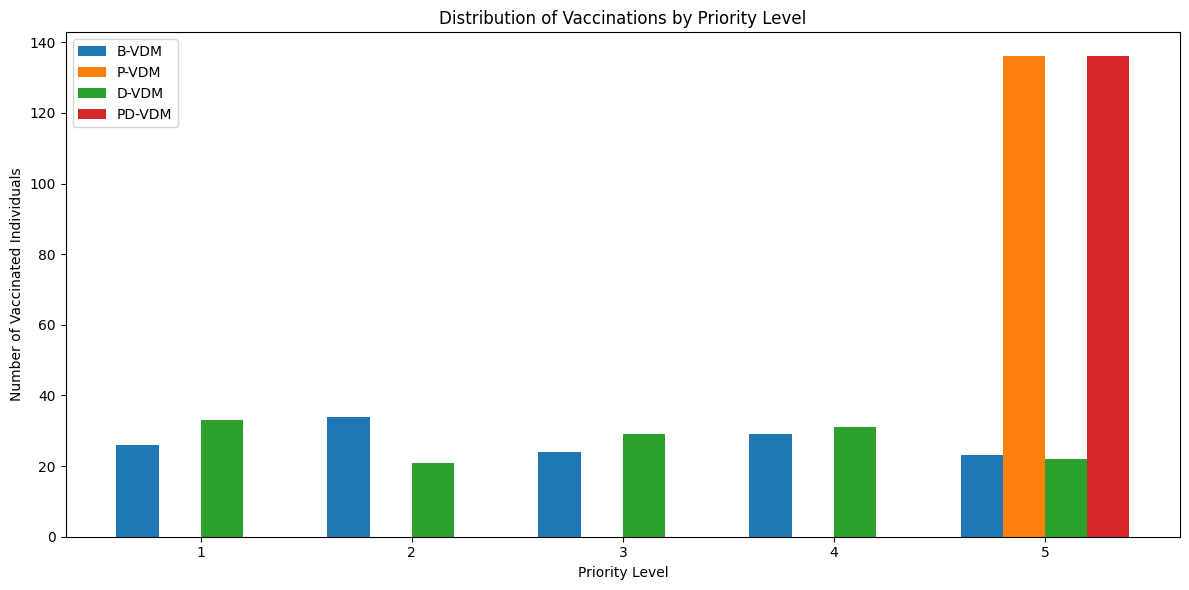

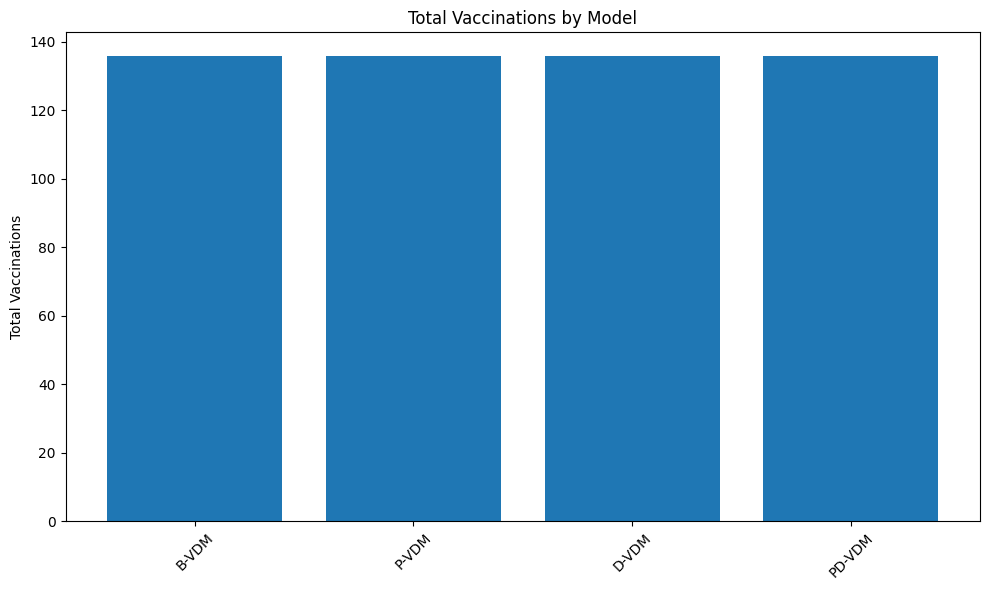

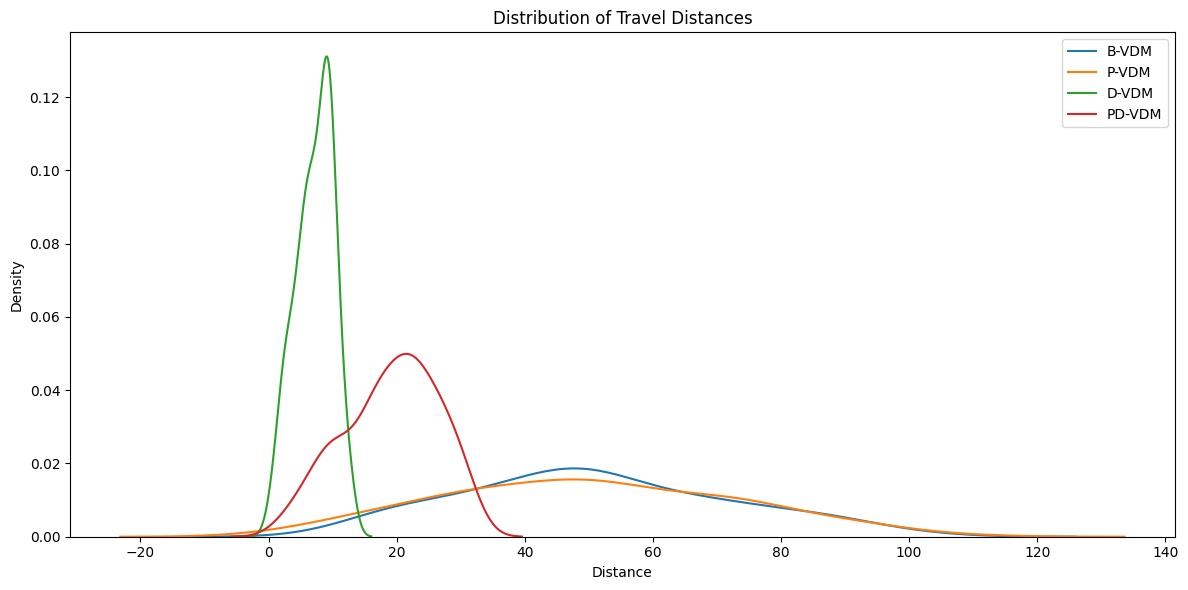

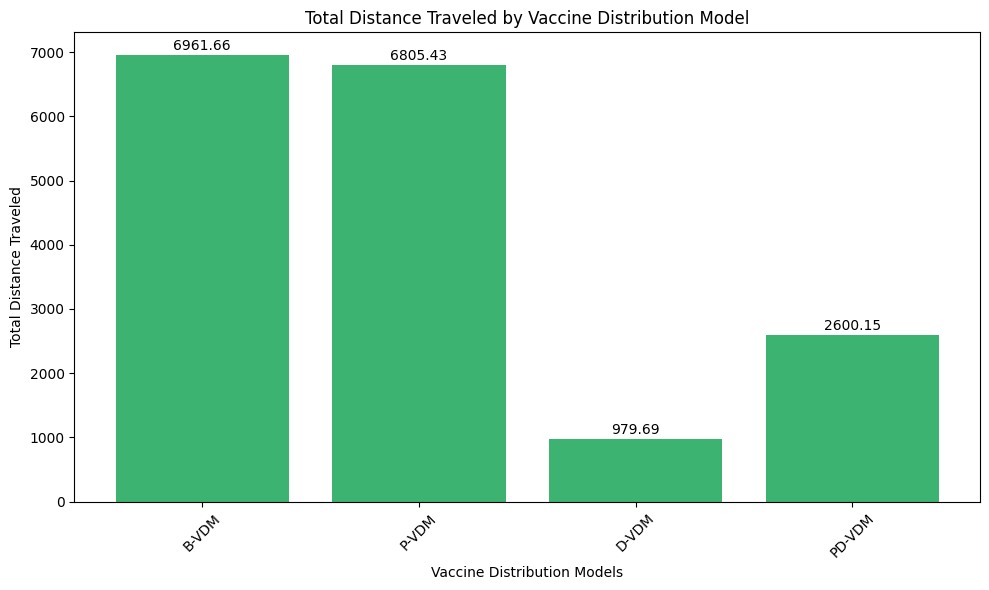

In [80]:
# Visualization of Results

class VaccinationVisualizer:
    def __init__(self, results: Dict[str, Dict]):
        """
        Initialize visualizer with results from all models
        results: Dictionary with keys 'B-VDM', 'P-VDM', 'D-VDM', 'PD-VDM'
        """
        self.results = results
        self.models = ['B-VDM', 'P-VDM', 'D-VDM', 'PD-VDM']

    def plot_priority_distribution(self):
        """Plot number of vaccinated individuals by priority level"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Get all unique priority levels across all models
        all_priorities = set()
        for model in self.models:
            if self.results[model]['assignments']:
                assignments = pd.DataFrame(self.results[model]['assignments'])
                all_priorities.update(assignments['priority'].unique())
        
        all_priorities = sorted(list(all_priorities))
        x = np.arange(len(all_priorities))
        width = 0.2
        
        for i, model in enumerate(self.models):
            if self.results[model]['assignments']:
                assignments = pd.DataFrame(self.results[model]['assignments'])
                counts = assignments['priority'].value_counts().reindex(all_priorities).fillna(0)
                ax.bar(x + i*width, counts.values, width, label=model)
        
        ax.set_xlabel('Priority Level')
        ax.set_ylabel('Number of Vaccinated Individuals')
        ax.set_title('Distribution of Vaccinations by Priority Level')
        ax.set_xticks(x + width*1.5)
        ax.set_xticklabels(all_priorities)
        ax.legend()
        plt.tight_layout()
        return fig

    def plot_total_vaccinations(self):
        """Plot total number of vaccinations for each model"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        totals = [self.results[model]['total_vaccinated'] for model in self.models]
        
        ax.bar(self.models, totals)
        ax.set_ylabel('Total Vaccinations')
        ax.set_title('Total Vaccinations by Model')
        plt.xticks(rotation=45)
        plt.tight_layout()
        return fig

    def plot_distance_distribution(self):
        """Plot distribution of travel distances"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for model in self.models:
            distances = [a['distance'] for a in self.results[model]['assignments']]
            sns.kdeplot(data=distances, label=model)
            
        ax.set_xlabel('Distance')
        ax.set_ylabel('Density')
        ax.set_title('Distribution of Travel Distances')    
        ax.legend()
        plt.tight_layout()
        return fig
    
    def plot_total_distance_traveled(self):
        """Plot total distance traveled by individuals for each model"""
        fig, ax = plt.subplots(figsize=(10, 6))

        total_distances = []
        for model in self.models:
            # Extract distances from assignments for the current model
            assignments = self.results[model]['assignments']
            distances = [assignment['distance'] for assignment in assignments]
            # Calculate total distance
            total_distance = sum(distances)
            total_distances.append(total_distance)

        # Create a bar plot for total distances
        ax.bar(self.models, total_distances, color='mediumseagreen')

        # Annotate each bar with the total distance value
        for i, total_distance in enumerate(total_distances):
            ax.text(i, total_distance + max(total_distances)*0.01, f"{total_distance:.2f}", ha='center')

        # Customize the plot
        ax.set_xlabel('Vaccine Distribution Models')
        ax.set_ylabel('Total Distance Traveled')
        ax.set_title('Total Distance Traveled by Vaccine Distribution Model')
        plt.xticks(rotation=45)
        plt.tight_layout()
        return fig
    

# Example usage
visualizer = VaccinationVisualizer(results)

# Plot priority distribution
priority_plot = visualizer.plot_priority_distribution()
priority_plot.savefig('priority_distribution.png')

# Plot total vaccinations
total_vaccinations_plot = visualizer.plot_total_vaccinations()
total_vaccinations_plot.savefig('total_vaccinations.png')

# Plot distance distribution
distance_distribution_plot = visualizer.plot_distance_distribution()
distance_distribution_plot.savefig('distance_distribution.png')

# Plot total distance traveled
total_distance_plot = visualizer.plot_total_distance_traveled()
total_distance_plot.savefig('total_distance_traveled.png')

# Plot Priority Distribution
Plot the number of vaccinated individuals by priority level.

/tmp/ipykernel_708468/2151087712.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  priority_plot.show()


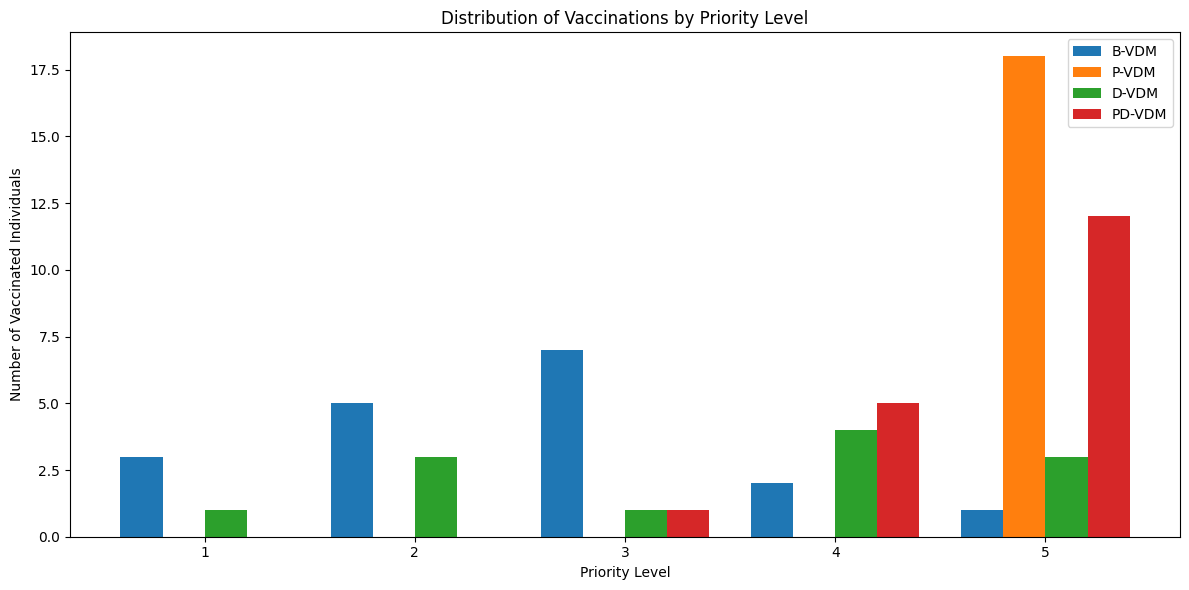

In [33]:
# Plot Priority Distribution

# Initialize the visualizer with the results from all models
visualizer = VaccinationVisualizer(results)

# Plot the priority distribution
priority_plot = visualizer.plot_priority_distribution()

# Display the plot
priority_plot.show()

# Plot Total Vaccinations
Plot the total number of vaccinations for each model.

/tmp/ipykernel_708468/961325613.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  total_vaccinations_plot.show()


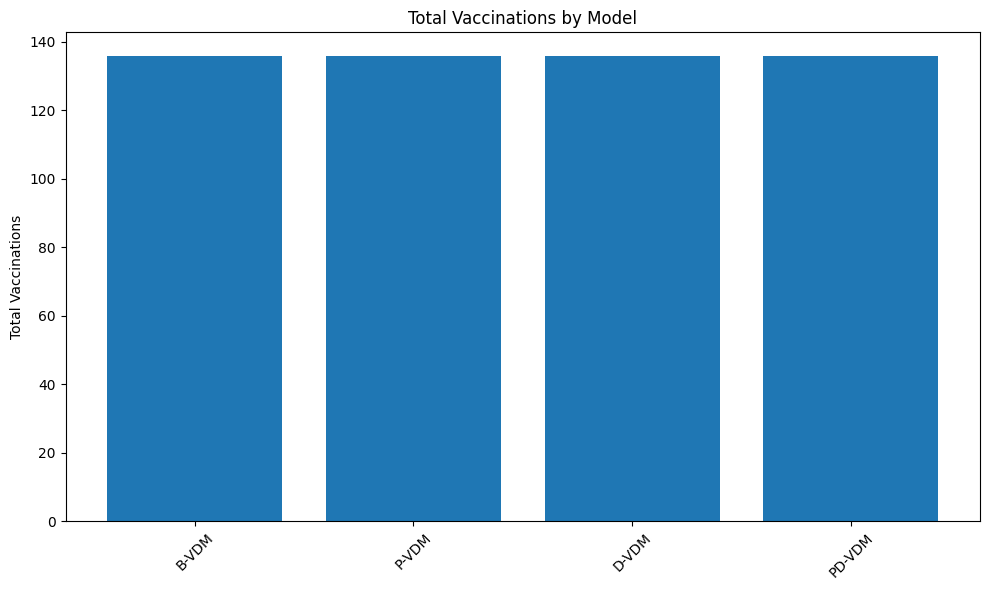

In [81]:
# Plot Total Vaccinations

# Plot the total number of vaccinations for each model
total_vaccinations_plot = visualizer.plot_total_vaccinations()

# Display the plot
total_vaccinations_plot.show()

# Plot Distance Distribution
Plot the distribution of travel distances.

/tmp/ipykernel_708468/3069147504.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distance_distribution_plot.show()


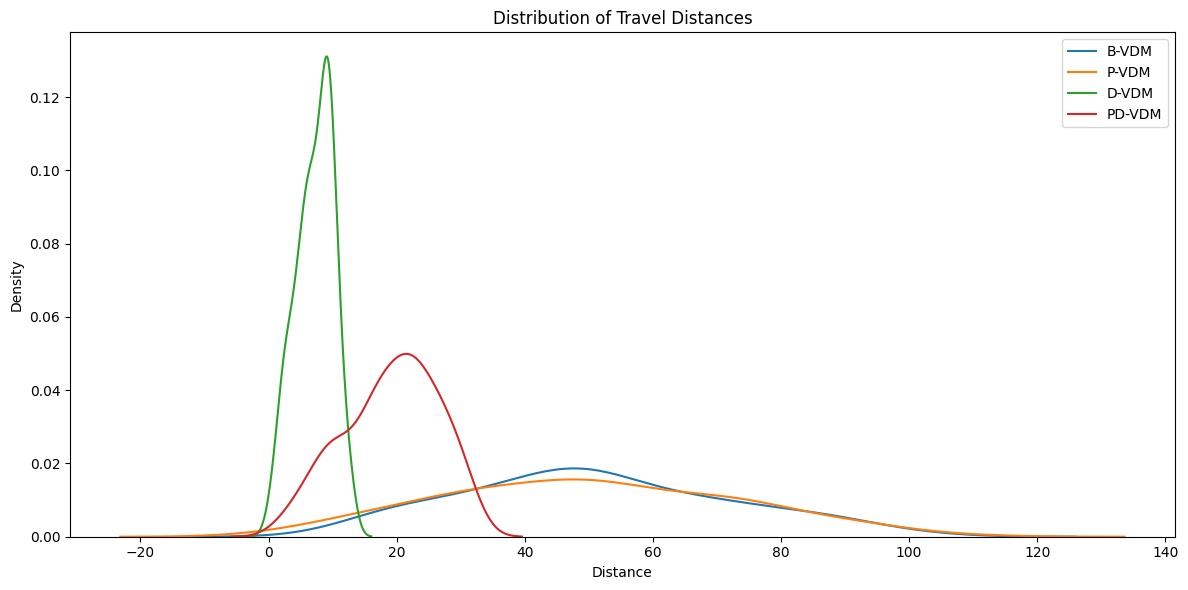

In [82]:
# Plot Distance Distribution

# Plot the distribution of travel distances
distance_distribution_plot = visualizer.plot_distance_distribution()

# Display the plot
distance_distribution_plot.show()